# Some tries for Fourrier transform-based autoencoder

In [1]:
#Let's first import the module that we will need
%matplotlib inline
import librosa
import librosa.display
import IPython.display as ipd
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pywt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D,Conv1D
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import metrics

import itertools

In [2]:
#Constant used throughout the notebook
PATH_TRAINING_DATASET = r"C:\Users\sylv_\Documents\audio for asd"

In [3]:
def build_dataframe(machine_str = 'valve'):
    #Get list of files in train and test directory
    path_train_folder = PATH_TRAINING_DATASET + "\\dev_" + machine_str + "\\" + machine_str + "\\train"
    path_test_folder = PATH_TRAINING_DATASET  + "\\dev_" + machine_str + "\\" + machine_str + "\\test"

    train_files = [f for f in os.listdir(path_train_folder)]
    test_files = [f for f in os.listdir(path_test_folder)]

    #Get list of dictionnary for creating DataFrame
    list_dict_file = []

    #Loop through filenames
    for filename in train_files:

        #Get filename as list of string
        splitted_filename = filename.split('_')

        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_train_folder + "\\" + filename,
            'filename' : filename,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:])        #.split('.')[0]  --> want to keep the complete suffix
        })

    #Loop through filenames
    for filename in test_files:

        #Get filename as list of string
        splitted_filename = filename.split('_')

        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_test_folder  + "\\" + filename,
            'filename' : filename,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:])     #.split('.')[0]  --> want to keep the complete suffix
        })
        
    return pd.DataFrame(list_dict_file)


def sound_from_file(filename, machine_str = 'valve', dataset = 'train'):
    df = build_dataframe(machine_str)
    path = PATH_TRAINING_DATASET + "\\dev_" + machine_str + "\\" + machine_str + "\\" + dataset + "\\" + filename
    return df[df['filepath']==path].iloc[0]
    


df_fan = build_dataframe('fan')
df_valve = build_dataframe('valve')
df_bearing = build_dataframe('bearing')
df_slider = build_dataframe('slider')
df_car = build_dataframe('ToyCar')
df_train = build_dataframe('ToyTrain')
df_gearbox = build_dataframe('gearbox')

df_fan.info()
df_fan.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filepath    3600 non-null   object
 1   filename    3600 non-null   object
 2   section     3600 non-null   int64 
 3   domain_env  3600 non-null   object
 4   dir         3600 non-null   object
 5   sound_type  3600 non-null   object
 6   id          3600 non-null   object
 7   suffix      3600 non-null   object
dtypes: int64(1), object(7)
memory usage: 225.1+ KB


,filepath,filename,section,domain_env,dir,sound_type,id,suffix
0,C:\Users\sylv_\Documents\audio for asd\dev_fan...,section_00_source_train_normal_0000_m-n_W.wav,0,source,train,normal,0000,m-n_W.wav
1,C:\Users\sylv_\Documents\audio for asd\dev_fan...,section_00_source_train_normal_0001_m-n_X.wav,0,source,train,normal,0001,m-n_X.wav
2,C:\Users\sylv_\Documents\audio for asd\dev_fan...,section_00_source_train_normal_0002_m-n_X.wav,0,source,train,normal,0002,m-n_X.wav
3,C:\Users\sylv_\Documents\audio for asd\dev_fan...,section_00_source_train_normal_0003_m-n_W.wav,0,source,train,normal,0003,m-n_W.wav
4,C:\Users\sylv_\Documents\audio for asd\dev_fan...,section_00_source_train_normal_0004_m-n_W.wav,0,source,train,normal,0004,m-n_W.wav


In [20]:
def load_audio(audio_path):
    return librosa.load(audio_path, sr=None)

def logMelSpectrogram(audio, fe, dt):
    # Spectrogramme
    stfts = np.abs(librosa.stft(audio,
                                n_fft=int(dt*fe),
                                hop_length=int(dt*fe),
                                center=True
                                )).T
    num_spectrogram_bins = stfts.shape[-1]
    # Filtre de MEL
    linear_to_mel_weight_matrix = librosa.filters.mel(
        sr=fe,
        n_fft=int(dt*fe) + 1,
        n_mels=num_spectrogram_bins,
    ).T

    # Application du filtre au spectrogramme
    mel_spectrograms = np.tensordot(
        stfts,
        linear_to_mel_weight_matrix,
        1
    )
    return np.log(mel_spectrograms + 1e-6)

def load_data(audio_path, dt=0.03):
    X_audio = []
    Y_audio=[]
    Z_audio=[]
    for i, a_path in enumerate(audio_path):
        # On charge les fichiers audio depuis les chemins
        data, fe = load_audio(a_path)

        # On applique la fonction logMelSpectrogram.
        #spectre_audio = logMelSpectrogram(data, fe, dt)
        spectre_ft = np.abs(librosa.stft(data, n_fft= int(fe*dt), hop_length = int(fe*dt)))
        #X_audio.append(spectre_audio)
        Y_audio.append(spectre_ft)
    a_audio = np.expand_dims(Y_audio, 3)
        #coeff, freq = pywt.cwt(data,scales=np.arange(1,129), wavelet='morl')
        #Z_audio.append(coeff)
    return np.array(a_audio)


def load_data_result(audio_path, dt=0.03):
    X_audio = []
    Y_audio=[]
    Z_audio=[]
    for i, a_path in enumerate(audio_path):
        # On charge les fichiers audio depuis les chemins
        data, fe = load_audio(a_path)
        spectre_ft = np.abs(librosa.stft(data, n_fft= int(fe*dt), hop_length = int(fe*dt)))
        Y_soundb1 = np.abs(spectre_ft) ** 2
        Y_log_soundb1 = librosa.power_to_db(Y_soundb1)
        Y_audio.append(Y_log_soundb1)
    a_audio = np.expand_dims(Y_audio, 3)
        #coeff, freq = pywt.cwt(data,scales=np.arange(1,129), wavelet='morl')
        #Z_audio.append(coeff)
    return np.array(a_audio)

## With Fourrier Transform on valve

In [13]:
df0 = df_valve # to change for other machines
df0 = df0.replace(to_replace = ['normal', 'anomaly'], value = [1, 0])

In [14]:
X= df0.drop(['sound_type'],1)
y=df0.sound_type

X_normal= X[y == 1]
X_anomaly= X[y == 0]

X_train_normal,X_test_normal = train_test_split(X_normal["filepath"] , test_size=0.5)

X_train_normal = load_data(X_train_normal)
X_test_normal = load_data(X_test_normal)
print(X_train_normal.shape)
print(X_test_normal.shape)

C:\Users\sylv_\AppData\Local\Temp\ipykernel_8736\3654273926.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X= df0.drop(['sound_type'],1)


(1650, 241, 334, 1)
(1650, 241, 334, 1)


In [15]:
autoencoder= Sequential()
from tensorflow.keras.layers import Conv2DTranspose, Reshape  
encodeur_1= Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=X_train_normal.shape[1:])
encodeur_2= Conv2D(32, kernel_size=(3, 3), activation='relu')
encodeur_3= Flatten()
encodeur_4= Dense(units= 64, activation='relu')
encodeur_5= Dense(units= 10, activation='relu')

decodeur_0= Dense(units= 10, activation='relu')
decodeur_1= Dense(units= 80494, activation='relu')
decodeur_2= Reshape((241,334,1))
decodeur_3= Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', padding='same')
decodeur_4= Conv2DTranspose(64, kernel_size=(3, 3), activation='relu', padding='same')
decodeur_5= Conv2DTranspose(1, kernel_size=(3, 3), activation='sigmoid', padding='same')

autoencoder.add(encodeur_1)
autoencoder.add(encodeur_2)
autoencoder.add(encodeur_3)
autoencoder.add(encodeur_4)
autoencoder.add(encodeur_5)

autoencoder.add(decodeur_0)
autoencoder.add(decodeur_1)
autoencoder.add(decodeur_2)
autoencoder.add(decodeur_3)
autoencoder.add(decodeur_4)
autoencoder.add(decodeur_5)

autoencoder.compile(loss='binary_crossentropy',optimizer='adam', metrics= ['mse'])
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 239, 332, 64)      640       
                                                                 
 conv2d_5 (Conv2D)           (None, 237, 330, 32)      18464     
                                                                 
 flatten_2 (Flatten)         (None, 2502720)           0         
                                                                 
 dense_8 (Dense)             (None, 64)                160174144 
                                                                 
 dense_9 (Dense)             (None, 10)                650       
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 80494)            

In [ ]:
history_autoencoder=autoencoder.fit(X_train_normal,X_train_normal, batch_size=20, 
                                    epochs=3 , validation_data= (X_test_normal,X_test_normal))

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(history_autoencoder.history['loss'], linewidth=2, label='Train')
plt.plot(history_autoencoder.history['val_loss'], linewidth=2, label='Validation')

plt.xlabel('Epoque')
plt.ylabel('Perte')
plt.title('Evolution de la fonction de perte', fontsize=15)
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.losses import mean_squared_error

X_train_normal_pred=autoencoder.predict(X_train_normal)
mse_train=mean_squared_error(X_train_normal,X_train_normal_pred)
print(np.percentile(mse_train,q=95))

X_test_normal_pred=autoencoder.predict(X_test_normal)
mse_test=mean_squared_error(X_test_normal,X_test_normal_pred)
print(np.percentile(mse_test,q=95))

In [ ]:
X_anomaly = load_data(X_anomaly["filepath"])

X_anomaly_pred=autoencoder.predict(X_anomaly)
mse2=mean_squared_error(X_anomaly,X_anomaly_pred)
print(np.percentile(mse2,q=95))

In [18]:
df0 = df_bearing
df0 = df0.replace(to_replace = ['normal', 'anomaly'], value = [1, 0])

In [21]:
X= df0.drop(['sound_type'],1)
y=df0.sound_type

X_normal= X[y == 1]
X_anomaly= X[y == 0]

X_train_normal,X_test_normal = train_test_split(X_normal["filepath"] , test_size=0.5)

X_train_normal_r = load_data_result(X_train_normal)
X_test_normal_r = load_data_result(X_test_normal)
X_train_normal = load_data(X_train_normal)
X_test_normal = load_data(X_test_normal)

print(X_train_normal.shape)
print(X_test_normal.shape)

C:\Users\sylv_\AppData\Local\Temp\ipykernel_8736\2178017215.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X= df0.drop(['sound_type'],1)


(1649, 241, 334, 1)
(1650, 241, 334, 1)


In [22]:
autoencoder= Sequential()
from tensorflow.keras.layers import Conv2DTranspose, Reshape  
encodeur_1= Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=X_train_normal.shape[1:])
encodeur_2= Conv2D(32, kernel_size=(3, 3), activation='relu')
encodeur_3= Flatten()
encodeur_4= Dense(units= 64, activation='relu')
encodeur_5= Dense(units= 10, activation='relu')

decodeur_0= Dense(units= 10, activation='relu')
decodeur_1= Dense(units= 80494, activation='relu')
decodeur_2= Reshape((241,334,1))
decodeur_3= Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', padding='same')
decodeur_4= Conv2DTranspose(64, kernel_size=(3, 3), activation='relu', padding='same')
decodeur_5= Conv2DTranspose(1, kernel_size=(3, 3), activation='sigmoid', padding='same')

autoencoder.add(encodeur_1)
autoencoder.add(encodeur_2)
autoencoder.add(encodeur_3)
autoencoder.add(encodeur_4)
autoencoder.add(encodeur_5)

autoencoder.add(decodeur_0)
autoencoder.add(decodeur_1)
autoencoder.add(decodeur_2)
autoencoder.add(decodeur_3)
autoencoder.add(decodeur_4)
autoencoder.add(decodeur_5)

autoencoder.compile(loss='binary_crossentropy',optimizer='adam', metrics= ['mse'])
autoencoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 239, 332, 64)      640       
                                                                 
 conv2d_7 (Conv2D)           (None, 237, 330, 32)      18464     
                                                                 
 flatten_3 (Flatten)         (None, 2502720)           0         
                                                                 
 dense_12 (Dense)            (None, 64)                160174144 
                                                                 
 dense_13 (Dense)            (None, 10)                650       
                                                                 
 dense_14 (Dense)            (None, 10)                110       
                                                                 
 dense_15 (Dense)            (None, 80494)            

In [23]:
history_autoencoder=autoencoder.fit(X_train_normal,X_train_normal_r, batch_size=20, 
                                    epochs=5 , validation_data= (X_test_normal,X_test_normal_r))

Epoch 1/5
83/83 [==============================] - 435s 5s/step - loss: -3363760640.0000 - mse: 1492.9272 - val_loss: -49732096000.0000 - val_mse: 1493.9558
Epoch 2/5
83/83 [==============================] - 428s 5s/step - loss: -29129357393920.0000 - mse: 1489.2543 - val_loss: -205196927959040.0000 - val_mse: 1493.9558
Epoch 3/5
83/83 [==============================] - 425s 5s/step - loss: -5674978406039552.0000 - mse: 1489.2540 - val_loss: -25503668274987008.0000 - val_mse: 1493.9558
Epoch 4/5
83/83 [==============================] - 423s 5s/step - loss: -212186537067020288.0000 - mse: 1489.2540 - val_loss: -700011362088124416.0000 - val_mse: 1493.9558
Epoch 5/5
83/83 [==============================] - 422s 5s/step - loss: -3161061844995538944.0000 - mse: 1489.2542 - val_loss: -8367017405561438208.0000 - val_mse: 1493.9558


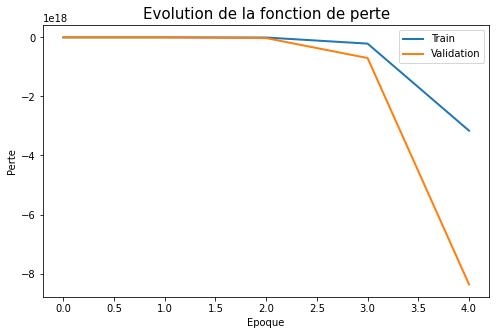

In [24]:
plt.figure(figsize=(8, 5))

plt.plot(history_autoencoder.history['loss'], linewidth=2, label='Train')
plt.plot(history_autoencoder.history['val_loss'], linewidth=2, label='Validation')

plt.xlabel('Epoque')
plt.ylabel('Perte')
plt.title('Evolution de la fonction de perte', fontsize=15)
plt.legend()
plt.show()

In [25]:
from tensorflow.keras.losses import mean_squared_error

X_train_normal_pred=autoencoder.predict(X_train_normal)
mse_train=mean_squared_error(X_train_normal_r,X_train_normal_pred)
print(np.percentile(mse_train,q=95))

X_test_normal_pred=autoencoder.predict(X_test_normal)
mse_test=mean_squared_error(X_test_normal_r,X_test_normal_pred)
print(np.percentile(mse_test,q=95))

52/52 [==============================] - 107s 2s/step
2554.924072265625
52/52 [==============================] - 106s 2s/step
2560.23828125


In [30]:
X_anomaly= X[y == 0]
X_anomaly_r = load_data_result(X_anomaly["filepath"])
X_anomaly = load_data(X_anomaly["filepath"])

X_anomaly_pred=autoencoder.predict(X_anomaly)
mse2=mean_squared_error(X_anomaly_r,X_anomaly_pred)
print(np.percentile(mse2,q=95))

10/10 [==============================] - 19s 2s/step
2575.73291015625


In [31]:
autoencoder= Sequential()
from tensorflow.keras.layers import Conv2DTranspose, Reshape  
encodeur_1= Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=X_train_normal.shape[1:])
encodeur_2= Conv2D(32, kernel_size=(3, 3), activation='relu')
encodeur_3= Flatten()
encodeur_4= Dense(units= 64, activation='relu')
encodeur_5= Dense(units= 10, activation='relu')

decodeur_0= Dense(units= 10, activation='relu')
decodeur_1= Dense(units= 80494, activation='relu')
decodeur_2= Reshape((241,334,1))
decodeur_3= Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', padding='same')
decodeur_4= Conv2DTranspose(64, kernel_size=(3, 3), activation='relu', padding='same')
decodeur_5= Conv2DTranspose(1, kernel_size=(3, 3), activation='sigmoid', padding='same')

autoencoder.add(encodeur_1)
autoencoder.add(encodeur_2)
autoencoder.add(encodeur_3)
autoencoder.add(encodeur_4)
autoencoder.add(encodeur_5)

autoencoder.add(decodeur_0)
autoencoder.add(decodeur_1)
autoencoder.add(decodeur_2)
autoencoder.add(decodeur_3)
autoencoder.add(decodeur_4)
autoencoder.add(decodeur_5)

autoencoder.compile(loss='binary_crossentropy',optimizer='adam', metrics= ['mse'])
autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 239, 332, 64)      640       
                                                                 
 conv2d_9 (Conv2D)           (None, 237, 330, 32)      18464     
                                                                 
 flatten_4 (Flatten)         (None, 2502720)           0         
                                                                 
 dense_16 (Dense)            (None, 64)                160174144 
                                                                 
 dense_17 (Dense)            (None, 10)                650       
                                                                 
 dense_18 (Dense)            (None, 10)                110       
                                                                 
 dense_19 (Dense)            (None, 80494)            

In [32]:
history_autoencoder=autoencoder.fit(X_train_normal_r,X_train_normal, batch_size=20, 
                                    epochs=5 , validation_data= (X_test_normal_r,X_test_normal))

Epoch 1/5
83/83 [==============================] - 423s 5s/step - loss: 0.1115 - mse: 0.0040 - val_loss: 0.0939 - val_mse: 4.9000e-04
Epoch 2/5
83/83 [==============================] - 427s 5s/step - loss: 0.0943 - mse: 4.8615e-04 - val_loss: 0.0935 - val_mse: 4.7519e-04
Epoch 3/5
83/83 [==============================] - 423s 5s/step - loss: 0.0941 - mse: 4.7641e-04 - val_loss: 0.0935 - val_mse: 4.6954e-04
Epoch 4/5
83/83 [==============================] - 422s 5s/step - loss: 0.0940 - mse: 4.7073e-04 - val_loss: 0.0937 - val_mse: 4.6814e-04
Epoch 5/5
83/83 [==============================] - 422s 5s/step - loss: 0.0938 - mse: 4.3708e-04 - val_loss: 0.0929 - val_mse: 3.9805e-04


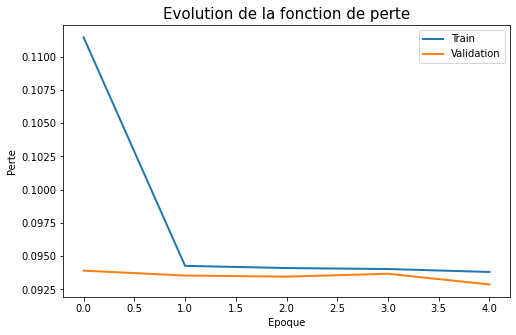

In [33]:
plt.figure(figsize=(8, 5))

plt.plot(history_autoencoder.history['loss'], linewidth=2, label='Train')
plt.plot(history_autoencoder.history['val_loss'], linewidth=2, label='Validation')

plt.xlabel('Epoque')
plt.ylabel('Perte')
plt.title('Evolution de la fonction de perte', fontsize=15)
plt.legend()
plt.show()

In [34]:
from tensorflow.keras.losses import mean_squared_error

X_train_normal_pred=autoencoder.predict(X_train_normal_r)
mse_train=mean_squared_error(X_train_normal,X_train_normal_pred)
print(np.percentile(mse_train,q=95))

X_test_normal_pred=autoencoder.predict(X_test_normal_r)
mse_test=mean_squared_error(X_test_normal,X_test_normal_pred)
print(np.percentile(mse_test,q=95))

52/52 [==============================] - 105s 2s/step
0.0011545117595233023
52/52 [==============================] - 105s 2s/step
0.001134574762545526


In [35]:
X_anomaly= X[y == 0]
X_anomaly_r = load_data_result(X_anomaly["filepath"])
X_anomaly = load_data(X_anomaly["filepath"])

X_anomaly_pred=autoencoder.predict(X_anomaly_r)
mse2=mean_squared_error(X_anomaly,X_anomaly_pred)
print(np.percentile(mse2,q=95))

10/10 [==============================] - 19s 2s/step
0.0013704688637517426
